In [34]:
import matplotlib.pyplot as plt
import pandas as pd
import pulp

In [35]:
curve = [
    "Apr'21", 2.921,
    "May'21", 2.892,
    "Jun'21", 2.922,
    "Jul'21", 2.96,
    "Aug'21", 2.974,
    "Sep'21", 2.966,
    "Oct'21", 3.007,
    "Nov'21", 3.07,
    "Dec'21", 3.203,
    "Jan'22", 3.294,
    "Feb'22", 3.216,
    "Mar'22", 3.03,
    "Apr'22", 2.568,
    "May'22", 2.48,
    "Jun'22", 2.525,
    "Jul'22", 2.562,
    "Aug'22", 2.57,
    "Sep'22", 2.559,
    "Oct'22", 2.592,
    "Nov'22", 2.681,
    "Dec'22", 2.87,
    "Jan'23", 2.987,
    "Feb'23", 2.939,
    "Mar'23", 2.779,
    "Apr'23", 2.388
]

In [36]:
df = pd.DataFrame( data={ 'Contract': curve[0::2], 'Price': curve[1::2]})

<AxesSubplot:xlabel='Contract'>

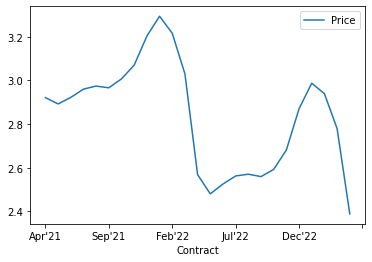

In [37]:
df.plot(x='Contract', y='Price')

In [46]:
N=3 # number of months to use
max_storage_capacity=100000
max_daily_injection=pd.DataFrame(data=[(0,8000),(0.5,8000),(0.5001,8000),(1.0,8000)], columns=['ratchet', 'mdiq'] )
max_daily_withdrawal=pd.DataFrame( data=[(0,9000),(0.5,9000),(0.5001,9000),(1.0,9000)], columns=['ratchet', 'mdwq'] )

<AxesSubplot:xlabel='ratchet'>

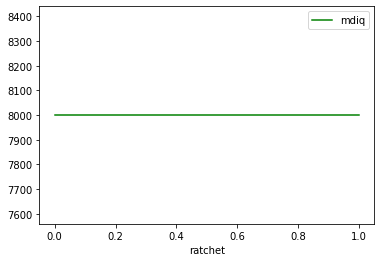

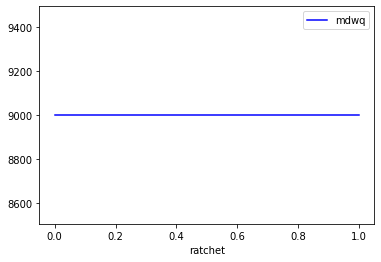

In [47]:
max_daily_injection.plot(x='ratchet',y='mdiq', style='g-')
max_daily_withdrawal.plot(x='ratchet',y='mdwq',style='b-')

In [67]:
# injection / withdrawal quantities
I=[None]*N
W=[None]*N
for i in range(N):
    I[i] = pulp.LpVariable(f'I_{i}', lowBound=0, cat='Integer')
    W[i] = pulp.LpVariable(f'W_{i}', lowBound=0, cat='Integer')    

In [68]:
# number of days in each injection / drawing month
days = list( map( lambda x: ((x+pd.DateOffset(months=1))-x).days, df.Contract.apply( lambda x: pd.to_datetime( '1-' + x ))))
days[0] = 2
days[1] = 2
days[2] = 2

# number of calendar days in the simulation
M = sum( days[0:N])

prices = list(df.Price)

In [69]:
injection_charges=[None]*N
total_injection=[None]*N
daily_injection=[None]*M

# for each injection month
for i in range(N):
    total_injection[i] = I[i]*10000
    injection_charges[i] = -total_injection[i] * prices[i]
    
for i in range(N):
    lb = sum(days[0:i])
    ub = sum(days[:i+1])
    daily_injection[lb:ub] = [ total_injection[i] / days[i] ] * days[i]

withdrawal_credit=[None]*N
total_draw=[None]*N
daily_draw=[None]*M

# for each drawing month
for j in range(N):
    total_draw[j] = W[j]*10000
    withdrawal_credit[j] = total_draw[j] * prices[j]
    
for i in range(N):
    lb = sum(days[0:i])
    ub = sum(days[:i+1])
    daily_draw[lb:ub]  = [ total_draw[i] / days[i] ] * days[i]

daily_storage=[None]*M
for i in range(M):
    if i == 0:
        daily_storage[i] = daily_injection[i] - daily_draw[i]
    else:
        daily_storage[i] = daily_injection[i] - daily_draw[i] + daily_storage[i-1]

In [70]:
storage_value_lp = pulp.LpProblem("NoRatchetsDaily", pulp.LpMaximize)

# target function
storage_value_lp += pulp.lpSum(withdrawal_credit) + pulp.lpSum(injection_charges)

# add constraints
for i in range(M):
    storage_value_lp += daily_storage[i] >= 0
    storage_value_lp += daily_storage[i] <= max_storage_capacity
    
# storage is empty on day 0
storage_value_lp += daily_injection[0] <= max_daily_injection.loc[0, 'mdiq']
storage_value_lp += daily_draw[0] <= max_daily_withdrawal.loc[ 0, 'mdwq']

for i in range(M-1):
    storage_value_lp += daily_injection[i+1] <= max_daily_injection.loc[0, 'mdiq']
    storage_value_lp += daily_draw[i+1] <= max_daily_withdrawal.loc[ 0, 'mdwq']
    
# ensure that storage on last day is empty
storage_value_lp += daily_storage[M-1] == 0

In [71]:
storage_value_lp.solve()
pulp.LpStatus[storage_value_lp.status]

'Optimal'

In [72]:
for variable in storage_value_lp.variables():
    if variable.varValue != 0.0:
        print( "{} = {}".format(variable.name, variable.varValue) )

I_0 = 1.0
I_1 = 1.0
W_0 = 1.0
W_2 = 1.0


In [73]:
print( pulp.value(storage_value_lp.objective) )

300.0


In [65]:
df_result = pd.DataFrame( data=map(lambda x: pulp.value(x), daily_storage), columns=['Gas in Storge'] )

<AxesSubplot:>

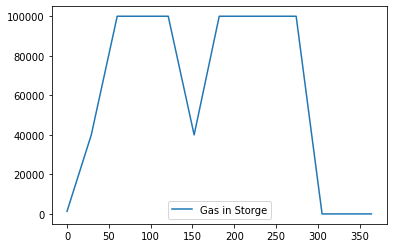

In [33]:
df_result.plot()

In [66]:
storage_value_lp

NoRatchetsDaily:
MAXIMIZE
-29210.0*I_0_ + -28920.0*I_1_ + -29220.0*I_2_ + 29210.0*W_0_ + 28920.0*W_1_ + 29220.0*W_2_ + 0.0
SUBJECT TO
_C1: 5000 I_0_ - 5000 W_0_ >= 0

_C2: 5000 I_0_ - 5000 W_0_ <= 100000

_C3: 10000 I_0_ - 10000 W_0_ >= 0

_C4: 10000 I_0_ - 10000 W_0_ <= 100000

_C5: 10000 I_0_ + 5000 I_1_ - 10000 W_0_ - 5000 W_1_ >= 0

_C6: 10000 I_0_ + 5000 I_1_ - 10000 W_0_ - 5000 W_1_ <= 100000

_C7: 10000 I_0_ + 10000 I_1_ - 10000 W_0_ - 10000 W_1_ >= 0

_C8: 10000 I_0_ + 10000 I_1_ - 10000 W_0_ - 10000 W_1_ <= 100000

_C9: 10000 I_0_ + 10000 I_1_ + 5000 I_2_ - 10000 W_0_ - 10000 W_1_ - 5000 W_2_
 >= 0

_C10: 10000 I_0_ + 10000 I_1_ + 5000 I_2_ - 10000 W_0_ - 10000 W_1_
 - 5000 W_2_ <= 100000

_C11: 10000 I_0_ + 10000 I_1_ + 10000 I_2_ - 10000 W_0_ - 10000 W_1_
 - 10000 W_2_ >= 0

_C12: 10000 I_0_ + 10000 I_1_ + 10000 I_2_ - 10000 W_0_ - 10000 W_1_
 - 10000 W_2_ <= 100000

_C13: 5000 I_0_ <= 8000

_C14: 5000 W_0_ <= 9000

_C15: 5000 I_0_ <= 8000

_C16: 5000 W_0_ <= 9000

_C17: 500